# Условие задания

Задача:
Построить две модели бинарной классификации текстов(комментарии на английском языке разделить на позитивные и негативные).

Исходные данные:
3 датасета — с комментариями, размеченные на позитивные -1 и негативные — 0.
Список датасетов: amazon_cells_labelled.txt, imdb_labelled.txt, yelp_labelled.txt.

1. Провести подготовку датасетов к классификации:

•	объединить датасеты в одну выборку

•	провести нормализацию(удаление знаков препинания, удаление стоп слов, приведение слов к начальной форме(стемминг))

•	разделить выборку на train и test подвыборки

•	привести подвыборки к формату TfiDF, сделать отсечение высокочастотных и низкочастотных слов

2. Построение моделей:

•	1-ая модель на randomforest классификаторе, 2-ая модель на KNeighbors(knn)

•	Для  randomforest настроить два гиперпараметра: количество деревьев, максимальная глубина дерева

•	Для knn настроить гиперпараметр  количество соседей

•	Обучить модели

•	Посчитать качество моделей на test подвыборке — выбрать показательную метрику для этой задачи

•	Сравнить результаты классфикации моделей, сделать выводы
 

Дополнительно:

•	Язык python3+

•	Код предоставить в jupyter notebook 

•	Можно использовать opensource библиотеки(scikit-learn, nltk, pandas, …)  

•	Привествуется использование pipeline

•	Выводы поместить в отдельныю ячейку  jupyter

•	Дополнительные гиперпарамтры в классификаторах можно оставить по умолчанию

•	Если в датасетах будут найдены «грязные» данные - их можно удалить


# Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from os import listdir, path

In [75]:
# Настройка параметров графиков
params = {'figure.figsize': (10, 6),
          'axes.labelsize': 16,
          'axes.titlesize': 26}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
# %matplotlib inline

Будем объединять датасеты сразу при чтении.

In [3]:
datasets_folder = r'datasets'
data = []
for file in listdir(datasets_folder):
    with open(path.join(datasets_folder, file), 'r') as f:
        data.extend(f.readlines())

Далее нужно разделить каждую запись на ее текст и оценку. По дороге приведем все к нижнему регистру.

In [4]:
data = [line.rstrip('\n').lower().split('\t') for line in data]

Теперь нужно собрать из этого датафрейм с двумя колонками - предложение, и класс

In [5]:
comments_df = pd.DataFrame.from_records(data, columns=['Text', 'Class'])
comments_df.head()

,Text,Class
0,so there is no way for me to plug it in here i...,0
1,"good case, excellent value.",1
2,great for the jawbone.,1
3,tied to charger for conversations lasting more...,0
4,the mic is great.,1


Далее можно поинтересоваться двумя вещами - распределением классов (вдруг они несбалансированны), и посмотреть на распределение комментариев по длине - таким образом можно найти неинформативные, "грязные" комментарии.

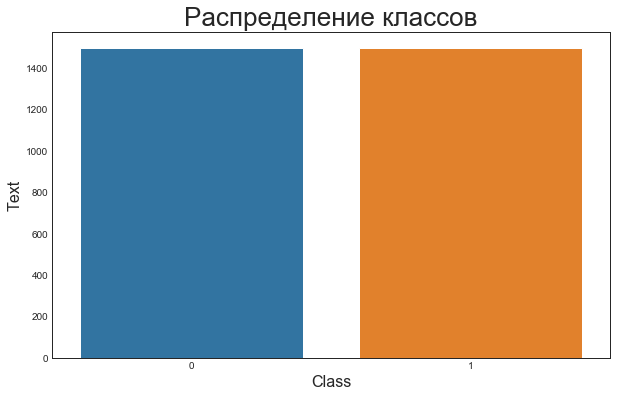

In [6]:
class_counter = comments_df.groupby('Class').count()
sns.barplot(class_counter.index, class_counter.Text)
plt.title('Распределение классов')
plt.show()

По классам все поровну. Далее мы из каждой строчки удалим все знаки препинания, и посчитаем количество символов в ней. Затем посмотрим, есть ли среди найденных строчек с, допустим, числом сиволов < 10 те, которые можно выбросить как неинформативные.

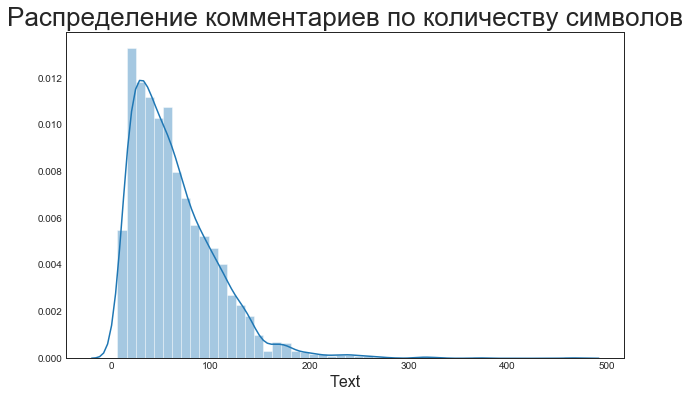

In [7]:
sent_len = comments_df['Text'].str.replace(r'[^\w\s]', '').apply(lambda x: len(x))
sns.distplot(sent_len)
plt.title('Распределение комментариев по количеству символов')
plt.show()

Выглядит вполне логично - большинство укладывается в формат твита - 140 символов. Если посмотреть на очень короткие комменты - там тоже ничего страшного - всё вполне информативно. Т.о. на первый взгляд ничего из выборки выкидывать не надо.

In [8]:
comments_df.iloc[sent_len[(sent_len.values < 10)].index]

,Text,Class
827,good case!.,1
857,(it works!),1
877,excellent!.,1
1125,10/10,1
1162,awful.,0
1198,so bad.,0
1493,see it.,1
1788,10/10,1
2165,delicious!!,1


Далее разделим подвыборки на трейн и тест

In [9]:
# этот сид будем использовать для всех дальнейших вычислений
random_seed = 42

In [10]:
data_values = comments_df['Text']
data_labels = comments_df['Class']

In [11]:
train_data, test_data, train_labels, test_labels = train_test_split(data_values,
                                                                    data_labels,
                                                                    random_state=random_seed,
                                                                    test_size=0.3)

Следующим пунктом идет нормализация текстов и приведение к формату TF-IDF. Раз разрешается использование pipeline, то почему бы не упростить им себе жизнь.

In [12]:
import nltk
nltk.download('stopwords')

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jeditem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Подготовительная часть пайплайна будет состоять из двух - CountVectorizer со стеммингом, и TfidfTransformer. Для стемминга модифицируем класс CountVectorizer так, чтобы он возвращал слова в начальной форме. Чтобы это все нормально работало в пайплайне, модифицируем метод build_analyzer.

In [13]:
stemmer = SnowballStemmer("english", ignore_stopwords=True)

In [14]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda text: ([stemmer.stem(w) for w in analyzer(text)])

In [15]:
# Создаем объект модифицированного CountVectorizer с отсечкой высокочастотных, низкочастотных, и стоп-слов
Stemmed_Count_Vect = StemmedCountVectorizer(stop_words='english',
                                            max_df=0.9, min_df=3)

Теперь можно собрать первую часть пайплайна.

In [16]:
sentence_pipeline = Pipeline([('vectorizer', Stemmed_Count_Vect),
                              ('transformer', TfidfTransformer())])
sentence_pipeline.fit_transform(train_data)

<2100x870 sparse matrix of type '<class 'numpy.float64'>'
	with 8609 stored elements in Compressed Sparse Row format>

# Построение моделей

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

Для обеих наших моделей заведем свои пайплайны.

In [18]:
forest_pipeline = Pipeline([('sentence',sentence_pipeline),
                            ('classifier', RandomForestClassifier(random_state=random_seed))])

In [19]:
knn_pipeline = Pipeline([('sentence',sentence_pipeline),
                         ('classifier', KNeighborsClassifier())])

## Подбор параметров для Random Forest

Требуется настроить всего два параметра - настроить два гиперпараметра: количество деревьев, максимальная глубина. Здесь сначала воспользуемся RandomizedSearchCV для быспрой оценки параметров, затем уточним с помощью GridSearchCV.

Так как никаких требований к метрике не предъявляется, возьмем accuracy - датасет сбалансированный, значит доля правильных ответов будет вполне актуально отражать качество модели.

In [33]:
forest_params = {'classifier__n_estimators': np.arange(2,201,1),
                 'classifier__max_depth': np.arange(1,50,1)}

In [34]:
forest_search = RandomizedSearchCV(estimator = forest_pipeline, 
                                   param_distributions = forest_params,
                                   scoring='accuracy',
                                   n_jobs=4,
                                   cv=5, verbose=1)

In [35]:
forest_search.fit(train_data, train_labels)
forest_search.best_params_, forest_search.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.0s finished


({'classifier__n_estimators': 185, 'classifier__max_depth': 44},
 0.7504761904761905)

In [39]:
new_forest_params = {'classifier__n_estimators': np.arange(180,201,1),
                     'classifier__max_depth': np.arange(35,50,1)}

In [40]:
new_forest_search = GridSearchCV(estimator = forest_pipeline, 
                                 param_grid = new_forest_params,
                                 scoring='accuracy',
                                 n_jobs=4,
                                 cv=5, verbose=1)

In [41]:
new_forest_search.fit(train_data, train_labels)
new_forest_search.best_params_, new_forest_search.best_score_

Fitting 5 folds for each of 315 candidates, totalling 1575 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   48.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done 1575 out of 1575 | elapsed:  6.7min finished


({'classifier__max_depth': 48, 'classifier__n_estimators': 180},
 0.7542857142857142)

Прирост точности всего 0,4%, это это мы еще среднеквадратичное отклонение не смотрели. Кстати

In [53]:
print(f'New forest params std: {new_forest_search.cv_results_["std_test_score"].mean()}')
print(f'First forest params std: {forest_search.cv_results_["std_test_score"].mean()}')

New forest params std: 0.018806734484093098
First forest params std: 0.01926658002881204


Новое отклонение ненамного лучше первого, да и в принципе, улучшение оценки на кросс-валидации на 0,4% при STD=0.2% - сомнительное улучшение, так что на этом подбор параметров можно остановить.

## Подбор параметров для KNNeighbors

Здесь для одного параметра можно сразу воспользоваться GridSearchCV

In [24]:
knn_params = {'classifier__n_neighbors': np.arange(2,201,1)}

In [30]:
knn_search = GridSearchCV(estimator = knn_pipeline, 
                        param_grid = knn_params,
                        scoring='accuracy',
                        n_jobs=4,
                        cv=5, verbose=1)

In [31]:
knn_search.fit(train_data, train_labels)

Fitting 5 folds for each of 199 candidates, totalling 995 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   36.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 995 out of 995 | elapsed:  1.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('sentence',
                                        Pipeline(memory=None,
                                                 steps=[('vectorizer',
                                                         StemmedCountVectorizer(analyzer='word',
                                                                                binary=False,
                                                                                decode_error='strict',
                                                                                dtype=<class 'numpy.int64'>,
                                                                                encoding='utf-8',
                                                                                input='content',
                                                                                lowercase=True,
                                        

In [32]:
knn_search.best_params_, knn_search.best_score_

({'classifier__n_neighbors': 56}, 0.7466666666666667)

## Обучение моделей и оценка качества

Обновим параметры моделей, затем обучим их, и сделаем предсказания.

In [54]:
forest_pipeline = Pipeline([('sentence',sentence_pipeline),
                            ('classifier', RandomForestClassifier(n_estimators=180,
                                                                  max_depth=48,
                                                                  random_state=random_seed))])

In [55]:
knn_pipeline = Pipeline([('sentence',sentence_pipeline),
                         ('classifier', KNeighborsClassifier(n_neighbors=56))])

In [56]:
%%timeit
forest_pipeline.fit(train_data, train_labels)

876 ms ± 35.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
%%timeit
knn_pipeline.fit(train_data, train_labels)

251 ms ± 19.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
forest_res = forest_pipeline.predict(test_data)

In [59]:
knn_res = knn_pipeline.predict(test_data)

In [60]:
print(f'Accuracy для RandomForestClassifier: {accuracy_score(forest_res, test_labels)}')
print(f'Accuracy для KNeighborsClassifier: {accuracy_score(knn_res, test_labels)}')

Accuracy для RandomForestClassifier: 0.7855555555555556
Accuracy для KNeighborsClassifier: 0.7422222222222222


Для интереса построим матрицы ошибок

In [121]:
from sklearn.metrics import confusion_matrix
labels = ['0', '1']
forest_cm = confusion_matrix(test_labels, forest_res, labels)
knn_cm = confusion_matrix(test_labels, knn_res, labels)

In [122]:
forest_cm_df = pd.DataFrame.from_records(forest_cm, columns=labels)
knn_cm_df = pd.DataFrame.from_records(knn_cm, columns=labels)

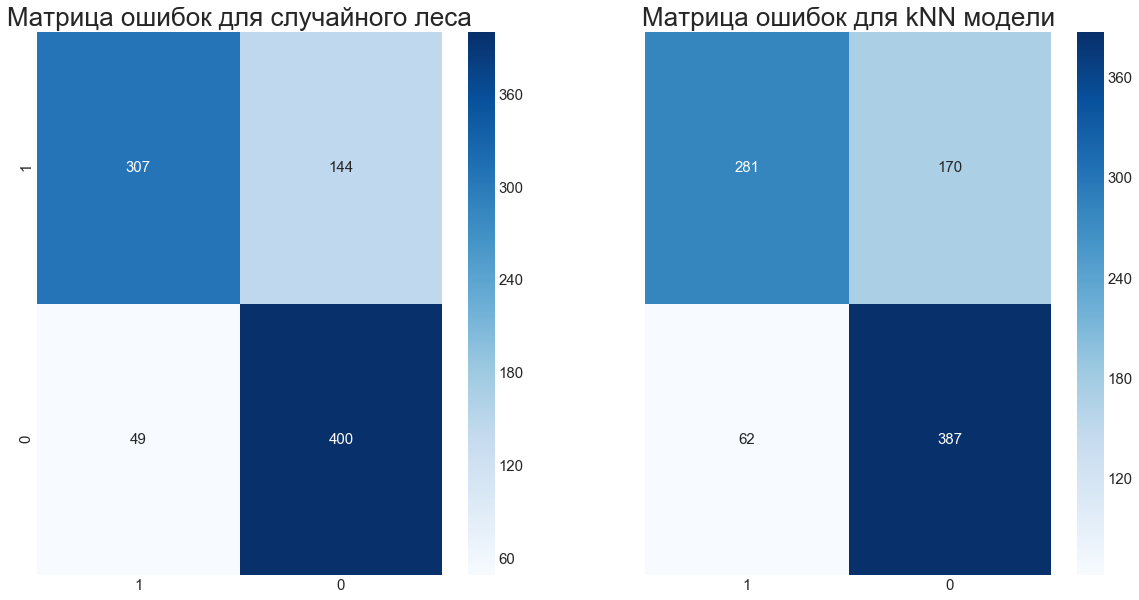

In [129]:
fig, ax = plt.subplots(1,2,sharey=True, figsize=(20, 10))
sns.heatmap(forest_cm_df, annot=True, fmt='', cmap='Blues', ax=ax[0])
sns.heatmap(knn_cm_df, annot=True, fmt='', cmap='Blues', ax=ax[1])
ax[0].set_ylim([0,2])
ax[0].set_xlim([2,0])
ax[1].set_xlim([2,0])
ax[0].title.set_text('Матрица ошибок для случайного леса')
ax[1].title.set_text('Матрица ошибок для kNN модели')

# Выводы

In [130]:
print(f'Accuracy для RandomForestClassifier: {accuracy_score(forest_res, test_labels)}')
print(f'Accuracy для KNeighborsClassifier: {accuracy_score(knn_res, test_labels)}')

Accuracy для RandomForestClassifier: 0.7855555555555556
Accuracy для KNeighborsClassifier: 0.7422222222222222


Для выбранной метрики Accuracy на отложенной выборке случайный лес показывает результат немного лучшне, чем модель на k ближайших соседей.

# Бонус

Попробуем объединить это все в ансамбль, и посмотреть на результаты.

In [139]:
from sklearn.ensemble import VotingClassifier
VCL = VotingClassifier(estimators=[('forest',forest_pipeline),('knn',knn_pipeline)],
                       voting='soft')

In [134]:
vote_score_test = np.mean(cross_val_score(
    VCL, 
    train_data, 
    train_labels, 
    scoring='accuracy', 
    cv=5))
print(vote_score_test)

0.7571428571428571


In [135]:
VCL.fit(train_data, train_labels)

VotingClassifier(estimators=[('forest',
                              Pipeline(memory=None,
                                       steps=[('sentence',
                                               Pipeline(memory=None,
                                                        steps=[('vectorizer',
                                                                StemmedCountVectorizer(analyzer='word',
                                                                                       binary=False,
                                                                                       decode_error='strict',
                                                                                       dtype=<class 'numpy.int64'>,
                                                                                       encoding='utf-8',
                                                                                       input='content',
                                                              

In [137]:
VCL_res = VCL.predict(test_data)

In [141]:
print(f'Accuracy для VotingClassifier: {accuracy_score(VCL_res, test_labels)}')

Accuracy для VotingClassifier: 0.7922222222222223


In [142]:
VCL_cm = confusion_matrix(test_labels, VCL_res, labels)
VCL_cm_df = pd.DataFrame.from_records(VCL_cm, columns=labels)

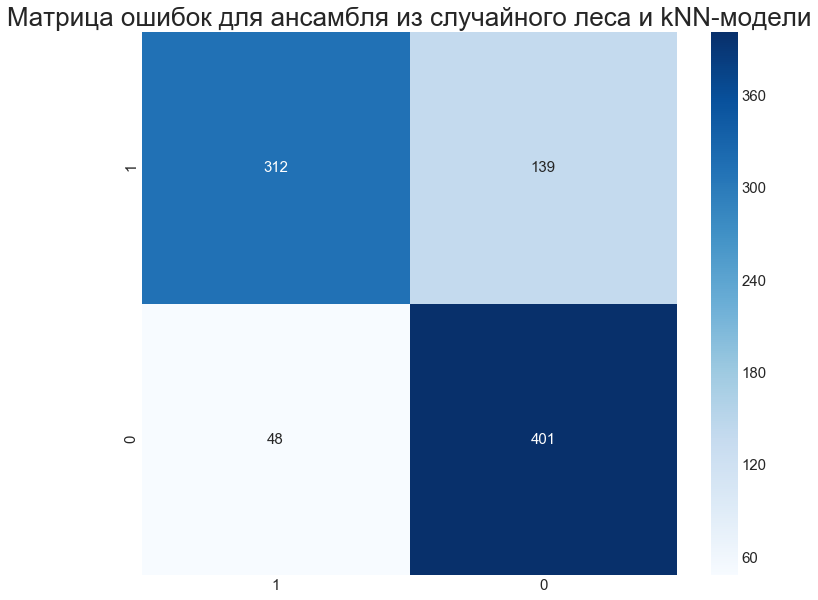

In [149]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(VCL_cm_df, annot=True, fmt='', cmap='Blues')
ax.set_ylim([0,2])
ax.set_xlim([2,0])
ax.title.set_text('Матрица ошибок для ансамбля из случайного леса и kNN-модели')

**Финальный вывод:** Объединение двух моделей при минимальном подборе основных параметров дает accuracy=0,79, что в целом хорошо, если считать это baseline-моделью.